# Setup


In [2]:
import os, time, copy
import pandas as pd
from PIL import Image, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
import wandb

import torch
import torchvision
import torch.nn as nn
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets, transforms, utils, models
import torch.optim as optim
from torch.optim import lr_scheduler
import ipynb.fs.full.shared_utilities as su

(1019, 26)


In [3]:
DATA_DIR = 'data'
EPOCHS = 25
LEARNING_RATE = 0.001
MOMENTUM = 0.9
STEP_SIZE = 7
GAMMA = 0.1

In [3]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eddiezhuang. Use `wandb login --relogin` to force relogin


True

In [16]:
wandb.init(project="paper-io-ai", config={
    "epochs": EPOCHS,
    "learning_rate": LEARNING_RATE,
    "momentum": MOMENTUM,
    "step_size": STEP_SIZE,
    "gamma": GAMMA
})

# Load Data


In [4]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

data = datasets.ImageFolder(DATA_DIR, data_transform)

train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_data, val_data = torch.utils.data.random_split(
    data, [train_size, val_size])
image_datasets = {
    'train': train_data,
    'val': val_data
}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = data.classes

device = torch.device("cuda:0")
torch.cuda.get_device_name(device)

AttributeError: module 'ipynb.fs.full.shared_utilities' has no attribute 'data_transform'

# Visualize Images

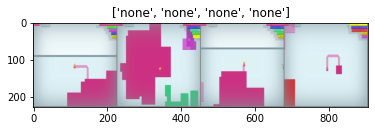

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485])
    std = np.array([0.229])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Train Model


In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS):
    wandb.watch(model, log_freq=100)

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) # load data to GPU
                labels = labels.to(device)

                optimizer.zero_grad() # clear gradients for this training step

                with torch.set_grad_enabled(phase == 'train'):
                    # Calculate loss
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            wandb.log({"loss": epoch_loss, "acc": epoch_acc})

            # save the model if it is the best so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    wandb.log({"best_acc": best_acc})

    model.load_state_dict(best_model_wts)
    return model

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_df = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=STEP_SIZE, gamma=GAMMA)

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, EPOCHS)

Epoch 1/25
----------
train Loss: 0.6836 Acc: 0.8498
val Loss: 0.5514 Acc: 0.8598

Epoch 2/25
----------
train Loss: 0.5560 Acc: 0.8514
val Loss: 0.4994 Acc: 0.8640

Epoch 3/25
----------
train Loss: 0.4738 Acc: 0.8493
val Loss: 0.5855 Acc: 0.7971

Epoch 4/25
----------
train Loss: 0.3830 Acc: 0.8692
val Loss: 0.4832 Acc: 0.8431

Epoch 5/25
----------
train Loss: 0.3155 Acc: 0.8849
val Loss: 0.4030 Acc: 0.8787

Epoch 6/25
----------
train Loss: 0.2940 Acc: 0.8917
val Loss: 0.5868 Acc: 0.7887

Epoch 7/25
----------
train Loss: 0.2454 Acc: 0.9063
val Loss: 0.4240 Acc: 0.8556

Epoch 8/25
----------
train Loss: 0.1505 Acc: 0.9403
val Loss: 0.3879 Acc: 0.8682

Epoch 9/25
----------
train Loss: 0.1097 Acc: 0.9613
val Loss: 0.3721 Acc: 0.8912

Epoch 10/25
----------
train Loss: 0.0908 Acc: 0.9728
val Loss: 0.3673 Acc: 0.8870

Epoch 11/25
----------
train Loss: 0.0906 Acc: 0.9676
val Loss: 0.3594 Acc: 0.8870

Epoch 12/25
----------
train Loss: 0.0709 Acc: 0.9785
val Loss: 0.3625 Acc: 0.8975

E

# Visualize Model Predictions

In [10]:
def visualize_model(model, num_images=6):
    """Shows predictions for a few images"""
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad(): # Reduces memory consumption for inference
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) # Returns the max output

            for j in range(inputs.size()[0]):
                images_so_far += 1

                # // divides and only keeps the integer part
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

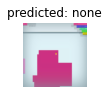

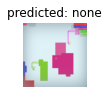

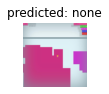

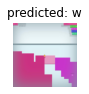

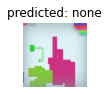

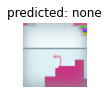

In [11]:
visualize_model(model_ft)

# Save Model


In [17]:
torch.save(model_ft, os.path.join(wandb.run.dir, 'model.pt'))

In [18]:
wandb.finish()